## part 1 : data acquisition + cleanup

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import default_collate

elephant_data = pd.read_csv("lfonts/ELEPHANT.csv")

# display(elephant_data)
pixel_columns = [col for col in elephant_data.columns if col.startswith('r') and 'c' in col]

keep_columns = ['m_label'] + pixel_columns

filtered_elephant_data = elephant_data[keep_columns]

display(filtered_elephant_data)

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,64258,1,1,1,1,1,5,66,151,189,...,57,124,243,255,255,255,255,255,179,105
1,64257,1,1,1,1,1,1,30,123,151,...,57,124,243,255,255,255,255,255,179,105
2,61442,1,1,1,1,1,5,66,151,189,...,57,124,243,255,255,255,255,255,179,105
3,61441,1,1,1,1,1,1,30,123,151,...,57,124,243,255,255,255,255,255,179,105
4,9674,1,1,1,1,1,1,1,110,255,...,255,161,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,37,1,1,1,30,112,161,161,161,54,...,1,1,50,67,67,32,1,1,1,1
908,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
909,35,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
910,34,1,1,1,31,119,255,255,255,255,...,255,153,11,1,1,1,1,1,1,1


/var/folders/3w/mkw0gknj67s61glj_9k16q480000gn/T/ipykernel_51537/68558621.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pixel_columns] = df[pixel_columns]/256.0


(912, 20, 20)
(912,)


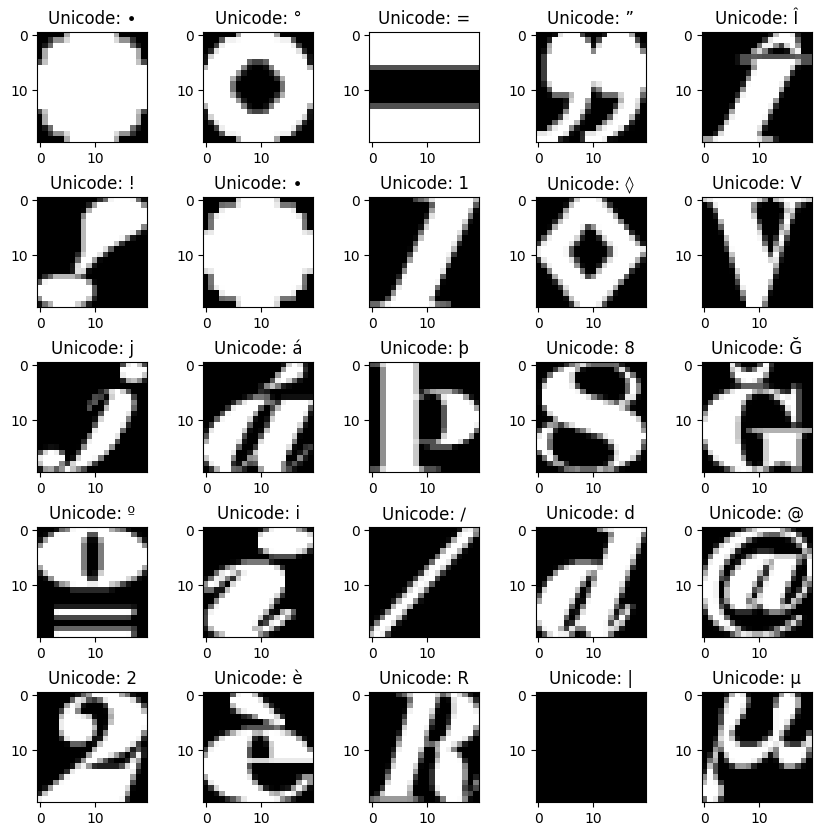

In [343]:
# creating dicitionaries for mapping the 

def dictionaries(df):
    #grabs the unique values and sorts them in ascending order
    unique_unicode_v = sorted(df['m_label'].unique())
    #unicode is they key and index is the value in the dictionary
    unicode_to_index = {unicode: index for index, unicode in enumerate(unique_unicode_v)}
    #reverse mapping of the unicode and index
    index_to_unicode = {index: unicode for unicode, index in unicode_to_index.items()}
    return unicode_to_index, index_to_unicode

unicode_to_index, index_to_unicode = dictionaries(elephant_data)


def transform(df, unicode_to_index):

    #normalizing pixel value
    df[pixel_columns] = df[pixel_columns]/256.0

    #extracting the pixel data as a numpy array
    Xs = df[pixel_columns].values.reshape(-1,20,20)

    #transforming unicode label to indices
    Ys = np.array([unicode_to_index[unicode] for unicode in df['m_label'].values])

    return Xs, Ys


Xs, Ys = transform(filtered_elephant_data, unicode_to_index)

print(Xs.shape)
print(Ys.shape)

def print_unicode_mapping(index_to_unicode):
    for index, unicode in index_to_unicode.items():
        print(f"index: {index}, unicode: {unicode} char: {chr(unicode)}")

#print_unicode_mapping(index_to_unicode)

num_to_print = 25

random = np.random.choice(len(Xs), num_to_print, replace=False)

plt.figure(figsize= (10, 10))
for i, idx in enumerate(random):
    plt.subplot( 5, 5, i+1 )
    plt.imshow(X[idx, : , :], cmap='gray', interpolation='none')
    plt.title(f'Unicode: {chr(index_to_unicode[Y[idx]])}')
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.show()




## part 2 : build a pytorch network

In [344]:



class CNN(nn.Module):

    #setting up layers and components of the CNN
    def __init__(self):
        super(CNN, self).__init__()
        # Set up 1st convolutional layer
        # Uses 6 filters, each w. kernel size of 3x3 pixels. 
        # The input has 1 channel (grayscale image). The output of this layer will be 6 feature maps
        self.conv1 = nn.Conv2d( 1, 6, 3 ) 
                
        self.pool = nn.MaxPool2d( 2, 2 ) # set up max pooling to be a 2x2 block
        
        # Set up 2nd convolutional layer
        # Uses 16 filters, each w. kernel size of 3x3 pixels. 
        # The input has 6 feature maps. The output of this layer will be 16 feature maps        
        self.conv2 = nn.Conv2d( 6, 16, 3 )
        
        # Set up 1st dense layer 
        # 3x3 grid per each of the 16 feature maps from conv2
        self.pooledOutputSize = 16 * 3 * 3 
        self.fc1 = nn.Linear( self.pooledOutputSize, 120 )
        
        #Set up 2nd and 3rd dense layers, which continue to refine the outputs towards the final classification layer
        self.fc2 = nn.Linear( 120, 84 )
        self.fc3 = nn.Linear( 84, 10 ) # predicts one of setSize classes (number of unique characters)

        # super(CNN, self).__init__()
        # #numver of output channels for the first and second convolution layers
        # c1Out = 6
        # c2Out = 16

        # #defining the first colvolution layer:
        # #input channels: 1 (the grayscale image of the ascii)
        # #output channels: c1Out - number of filters
        # #Kernel size: 3x2 pixels
        # self.conv1 = nn.Conv2d(1, c1Out, 3) 

        # #define the max pooling layer:
        # #kernel size: 2x2 pixels
        # #stride: 2 (downsamples the input by a factor of 2)
        # self.pool = nn.MaxPool2d(2,2) 

        # #define the second convolution layer:
        # #input channels: c1Out - output from the first conv layer
        # #output channels: c2Out - number of filters
        # #kernel size: 3x3 pixels
        # self.conv2 = nn.Conv2d(c1Out, c2Out, 3)

        # #define fully connected layers dense
        # #the input features: c2Out *5 *% flattened output from conv layers
        # #output features: 120
        # self.fc1 = nn.Linear(c2Out *6 *6 , 120)

        # #define the second fully connected layer:
        # #input features : 120
        # #output features: 84
        # self.fc2 = nn.Linear(120,84)

        # #define third fully connected layer:
        # #input features 84
        # #output features 10 ( number of classes for classification)
        # self.fc3 = nn.Linear(84,10)

    def forward(self, x): # "batch" of images
      #x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        #after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        #after max pool: (batch size, width/2, height/2, conv1 # outputs)
       # print(x.shape)
        #x = F.relu(self.conv1(x))
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        #print(x.shape)
        # print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        #split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        x = self.pool(F.relu(self.conv2(x))) #ditto
        #print(x.shape) #ncomment to see the size of this layer.  It helped me figure out what pooledOutputSize shoudl be

        #turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        #print(x.shape)
        # x = x.view(x.shape[0], -1)  #equivalent ways of reshaping the data to be 1D
        # x = x.view(batch_size( x.shape[0]) , -1)
        x = F.relu(self.fc1(x)) #apply dense layer 1
        x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc3(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features





In [345]:
#my model to be trained
#epochs: number of complete passes through the entire dataset
def train(my_model, epochs, my_data):
    criterion = nn.CrossEntropyLoss() #measure error for classification
    
    #use the ADAM optimizer to find the best weights
    optimizer = optim.Adam(my_model.parameters(), lr= 1e-4)

    #loading data and get in the right format
    trainloader = DataLoader(my_data, batch_size=8, shuffle= True, num_workers=0)

    my_model.train()
    
    #loop over the dataset multiple times
    for epoch in range(epochs):

        running_loss = 0.0
        for inputs , labels in trainloader:
            #get the inputs; data is a lost of [inputs, labels]
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            #forward+backward+optimize
            outputs = my_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d,%5d] loss: #.3f' % (epoch + 1, i+1, running_loss/2000))
                running_loss = 0.0
    print('finished training!')

#preparing training and testing data:


x_tensor = torch.tensor(Xs, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(Ys, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, random_state=1, test_size = 0.9)

training_data = TensorDataset(x_train, y_train)
testing_data = TensorDataset(x_test, y_test)

    #training here
#

device = ("mps" if torch.backends.mps.is_available() else "cpu")
print("device: ", device)
net = CNN().to(device=device)
train(net, 15, training_data)


device:  mps
finished training!


Using device: cpu
CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Evaluating...
Predicted labels: tensor([2, 2, 2, 2, 2, 2, 2, 7])
True labels: tensor([ 36,  79, 116, 194,  13,  80, 160, 228])
Predicted labels: tensor([2, 7, 2, 7, 2, 7, 7, 2])
True labels: tensor([ 27,  20,  46, 124,  76, 189, 111, 103])
Predicted labels: tensor([2, 2, 2, 7, 2, 7, 2, 2])
True labels: tensor([ 52,  98, 137, 222, 148, 211,  44, 194])
Predicted labels: tensor([2, 7, 7, 2, 7, 7, 7, 7])
True labels: tensor([176,  20, 192, 102,   8,  29,   4, 105])
Predicted labels: tensor([2, 7, 7, 7, 7, 2, 2, 2])
True labels: tensor([ 71,  54, 120, 193, 196, 225, 161, 202])
Predicted

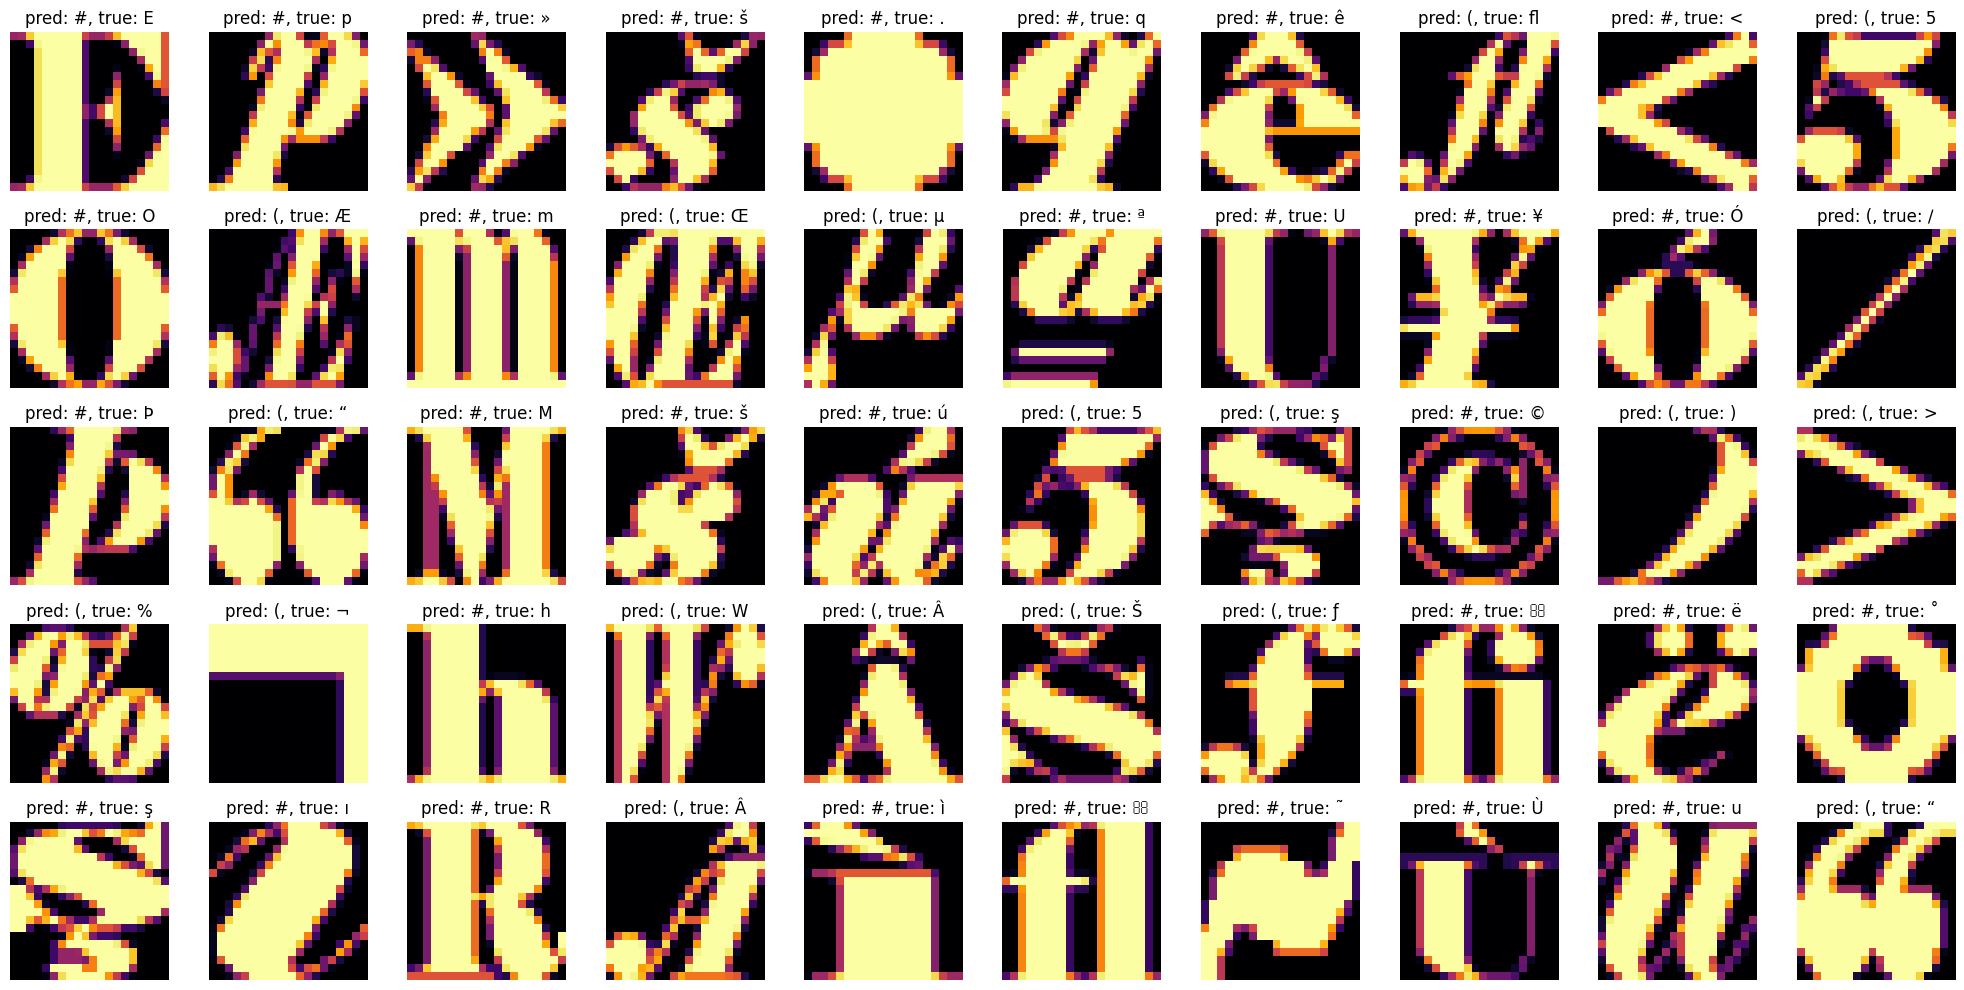

In [346]:
# Function to evaluate the model on test data
def evaluate(model, test_data):
    testloader = DataLoader(test_data, batch_size=8, shuffle=False)  # DataLoader for test data
    correct = 0
    total = 0
    incorrect_images = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to device (CPU or GPU)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted labels

            print("Predicted labels:", predicted)
            print("True labels:", labels)

            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

             # Visualization of incorrectly classified images
            for i in range(len(predicted)):
                if predicted[i] != labels[i]:
                    incorrect_images.append((images[i, 0].cpu(), predicted[i].item(), labels[i].item()))


    # Calculate accuracy
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test images: %.2f %%' % accuracy)

    plot_incorrect_images(incorrect_images, index_to_unicode)


def plot_incorrect_images(incorrect_images, index_to_unicode):
    num_images = len(incorrect_images)
    rows = 5
    cols = 10
    plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(min(num_images, rows * cols)):
        image, predicted_label, true_label = incorrect_images[i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.numpy(), cmap='inferno')
        if predicted_label in index_to_unicode and true_label in index_to_unicode:
            plt.title(f'pred: {chr(index_to_unicode[predicted_label])}, true: {chr(index_to_unicode[true_label])}')
        else:
            plt.title(f'uk: pred {predicted_label}, true: {true_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Assuming `net` is your CNN model instance
net = CNN().to(device=device)  # Move model to device
print(net)  # Print model architecture

# Assuming `x_test` and `y_test` are your test data tensors
testing_data = TensorDataset(x_test, y_test)  # Create a dataset from test tensors

print("Evaluating...")
evaluate(net, testing_data)  # Evaluate the model on test data

